# **Medium Risk Modelling**

## **Library**

In [18]:
#main
import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

#viz
import seaborn as sns 
import matplotlib.pyplot as plt 

#mod
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM, Dropout 
from sklearn.metrics import mean_absolute_error

In [2]:
list_file = os.listdir('/content/midrisk')
list_file

['Eastspring Syariah Fixed Income Amanah Kelas A Clean.csv',
 'Eastspring IDR Fixed Income Fund Kelas A Clean.csv',
 'Sucorinvest Sharia Sukuk Funds Clean.csv',
 'Sucorinvest Stable Fund Clean.csv',
 'Manulife Obligasi Negara Indonesia II Kelas A Clean.csv',
 'Schroder Dana Mantap Plus II Clean.csv',
 'Danamas_Stabil Clean.csv',
 'Batavia Dana Obligasi Ultima.csv',
 'Manulife Obligasi Unggulan Kelas A.csv',
 'ABF Indonesia Bond Index Fund Clean.csv']

In [3]:
dataset = []
for file in list_file:
  name = file.split('.')[0]
  dataset.append(name)
print(dataset)

['Eastspring Syariah Fixed Income Amanah Kelas A Clean', 'Eastspring IDR Fixed Income Fund Kelas A Clean', 'Sucorinvest Sharia Sukuk Funds Clean', 'Sucorinvest Stable Fund Clean', 'Manulife Obligasi Negara Indonesia II Kelas A Clean', 'Schroder Dana Mantap Plus II Clean', 'Danamas_Stabil Clean', 'Batavia Dana Obligasi Ultima', 'Manulife Obligasi Unggulan Kelas A', 'ABF Indonesia Bond Index Fund Clean']


In [4]:
df = {}
for i in dataset:
  df[i] = pd.read_csv('/content/midrisk/' +i +'.csv')

In [5]:
df['Schroder Dana Mantap Plus II Clean'].head()

,Unnamed: 0,date,value,Next,Class
0,0,2022/9/16,2883.51,2884.20,1
1,1,2022/9/19,2884.20,2885.51,1
2,2,2022/9/20,2885.51,2883.12,0
3,3,2022/9/21,2883.12,2878.81,0
4,4,2022/9/22,2878.81,2871.94,0


In [6]:
df['Schroder Dana Mantap Plus II Clean'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  66 non-null     int64  
 1   date        66 non-null     object 
 2   value       66 non-null     float64
 3   Next        65 non-null     float64
 4   Class       66 non-null     int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 2.7+ KB


In [7]:
for i in dataset:
  df[i]['date'] = pd.to_datetime(df[i]['date']) 

In [8]:
df['Schroder Dana Mantap Plus II Clean'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  66 non-null     int64         
 1   date        66 non-null     datetime64[ns]
 2   value       66 non-null     float64       
 3   Next        65 non-null     float64       
 4   Class       66 non-null     int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 2.7 KB


In [9]:
df_new = {}
for i in dataset:
  size = int(len(df[i]) * 0.8)
  df_new[i] = {}
  df_new[i]['train'] = df[i]['value'].iloc[0:size]
  df_new[i]['test'] = df[i]['value'].iloc[size-1:len(df[i])]

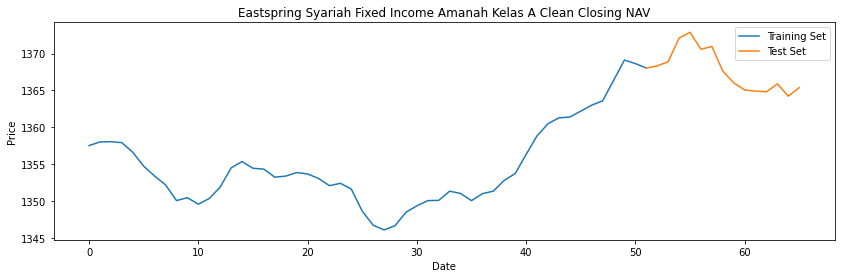

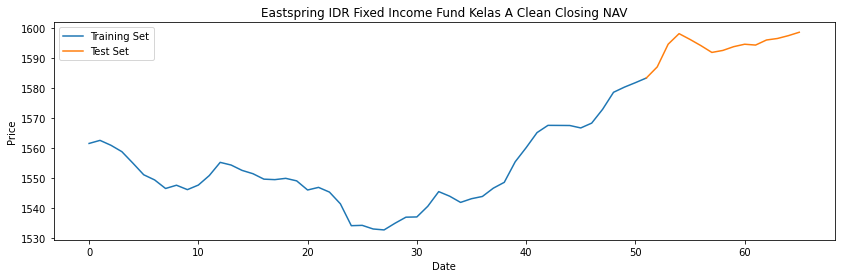

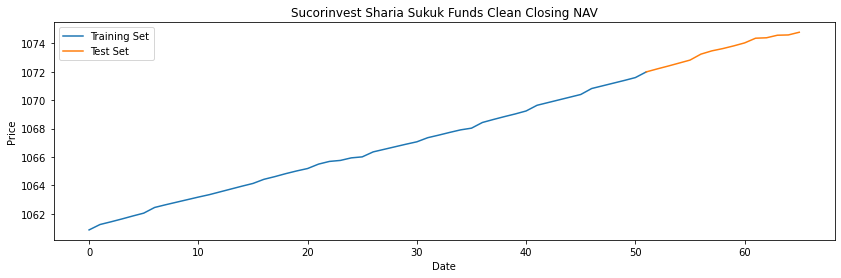

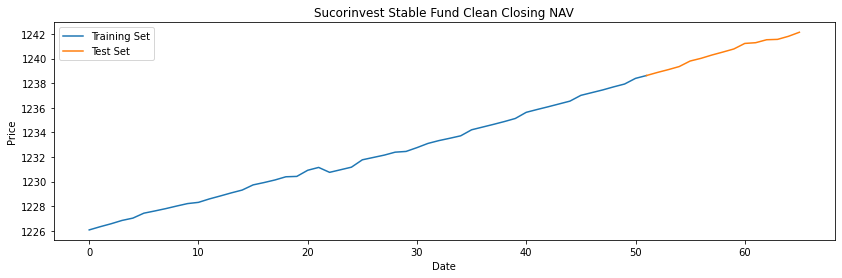

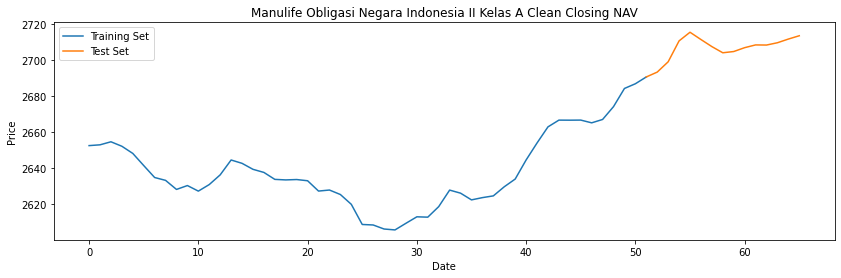

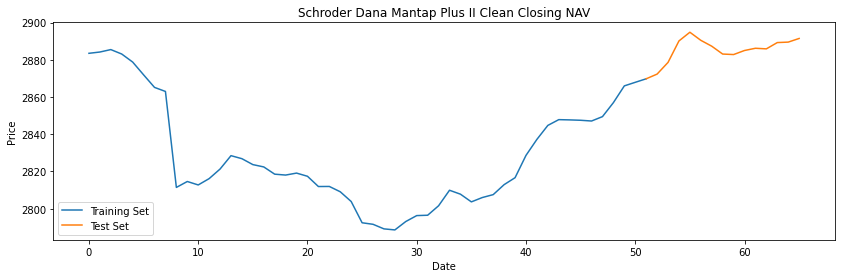

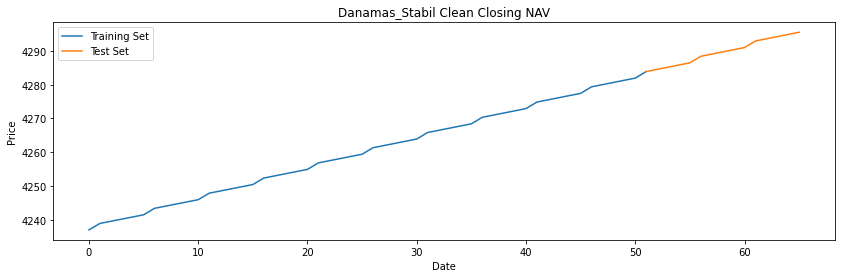

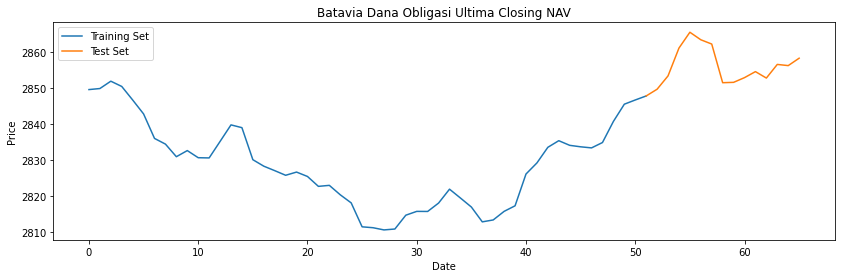

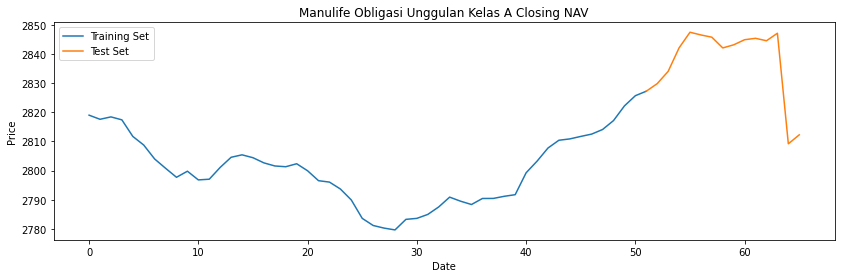

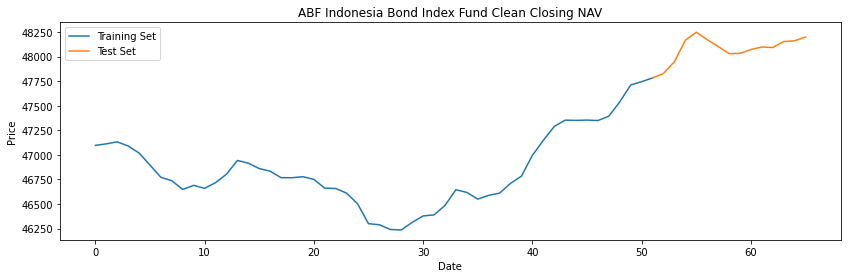

In [10]:
for i in dataset:
    plt.figure(figsize=(14,4))
    plt.plot(df_new[i]["train"])
    plt.plot(df_new[i]["test"])
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend(["Training Set", "Test Set"])
    plt.title(i + " Closing NAV")

In [11]:
# Scaling the training set
transform_train = {}
transform_test = {}
scaler = {}

for num, i in enumerate(dataset):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(df_new[i]["train"])
    a1 = np.array(df_new[i]["test"])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train[i] = sc.fit_transform(a0)
    transform_test[i] = sc.fit_transform(a1)
    scaler[i] = sc
    
del a0
del a1

In [12]:
transform_test["Manulife Obligasi Unggulan Kelas A"].shape

(15, 1)

In [14]:
trainset = {}
testset = {}
for j in dataset:
    trainset[j] = {}
    X_train = []
    y_train = []
    for i in range(1, 48):
        X_train.append(transform_train[j][i-1:i,0])
        y_train.append(transform_train[j][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
    trainset[j]["y"] = y_train
    
    testset[j] = {}
    X_test = []
    y_test = []    
    for i in range(1,14):
        X_test.append(transform_test[j][i-1:i,0])
        y_test.append(transform_test[j][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
    testset[j]["y"] = y_test

In [16]:
arr_buff = []
for i in dataset:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=dataset)

,X_train,y_train,X_test,y_test
Eastspring Syariah Fixed Income Amanah Kelas A Clean,"(47, 1, 1)","(47,)","(13, 1, 1)","(13,)"
Eastspring IDR Fixed Income Fund Kelas A Clean,"(47, 1, 1)","(47,)","(13, 1, 1)","(13,)"
Sucorinvest Sharia Sukuk Funds Clean,"(47, 1, 1)","(47,)","(13, 1, 1)","(13,)"
Sucorinvest Stable Fund Clean,"(47, 1, 1)","(47,)","(13, 1, 1)","(13,)"
Manulife Obligasi Negara Indonesia II Kelas A Clean,"(47, 1, 1)","(47,)","(13, 1, 1)","(13,)"
Schroder Dana Mantap Plus II Clean,"(47, 1, 1)","(47,)","(13, 1, 1)","(13,)"
Danamas_Stabil Clean,"(47, 1, 1)","(47,)","(13, 1, 1)","(13,)"
Batavia Dana Obligasi Ultima,"(47, 1, 1)","(47,)","(13, 1, 1)","(13,)"
Manulife Obligasi Unggulan Kelas A,"(47, 1, 1)","(47,)","(13, 1, 1)","(13,)"
ABF Indonesia Bond Index Fund Clean,"(47, 1, 1)","(47,)","(13, 1, 1)","(13,)"


# Models

In [19]:
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_mae') is not None and logs.get('val_mae') < 0.015:
      self.model.stop_training = True

In [20]:
# model = Sequential([LSTM(64, input_shape=(1, 1), return_sequences=True),
#                     LSTM(32),
#                     Dense(25, activation='relu'),
#                     Dense(1)])

In [22]:
%%time
# The LSTM architecture
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.1))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compiling the RNN
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, 
              metrics=["mae"], 
              loss=tf.keras.losses.Huber())

#Training Models
for i in dataset:
    print("Train to", i)
    model.fit(trainset[i]["X"], 
              trainset[i]["y"], 
              epochs=1000, 
              batch_size=8,
              validation_data=(X_test, y_test), 
              shuffle=False,
              callbacks=[Callback()])

Streaming output truncated to the last 5000 lines.
Epoch 503/1000
6/6 [==============================] - 0s 19ms/step - loss: 0.0037 - mae: 0.0669 - val_loss: 0.0159 - val_mae: 0.1338
Epoch 504/1000
6/6 [==============================] - 0s 18ms/step - loss: 0.0031 - mae: 0.0560 - val_loss: 0.0159 - val_mae: 0.1338
Epoch 505/1000
6/6 [==============================] - 0s 18ms/step - loss: 0.0032 - mae: 0.0617 - val_loss: 0.0159 - val_mae: 0.1340
Epoch 506/1000
6/6 [==============================] - 0s 21ms/step - loss: 0.0039 - mae: 0.0679 - val_loss: 0.0159 - val_mae: 0.1337
Epoch 507/1000
6/6 [==============================] - 0s 18ms/step - loss: 0.0036 - mae: 0.0643 - val_loss: 0.0157 - val_mae: 0.1327
Epoch 508/1000
6/6 [==============================] - 0s 17ms/step - loss: 0.0029 - mae: 0.0613 - val_loss: 0.0156 - val_mae: 0.1320
Epoch 509/1000
6/6 [==============================] - 0s 19ms/step - loss: 0.0041 - mae: 0.0680 - val_loss: 0.0156 - val_mae: 0.1316
Epoch 510/1000
6/6

1/1 [==============================] - 0s 69ms/step


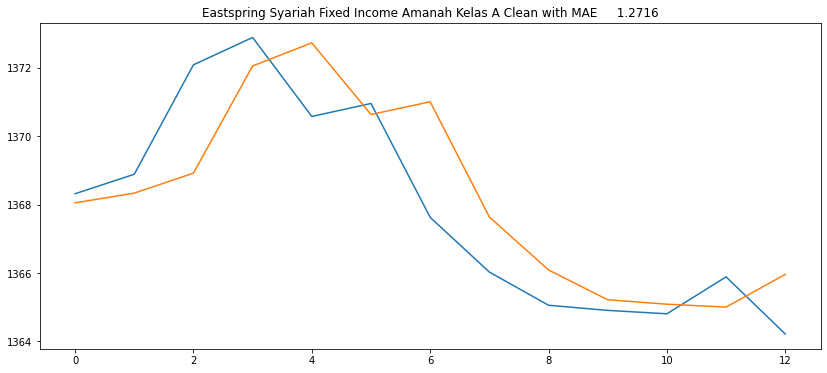

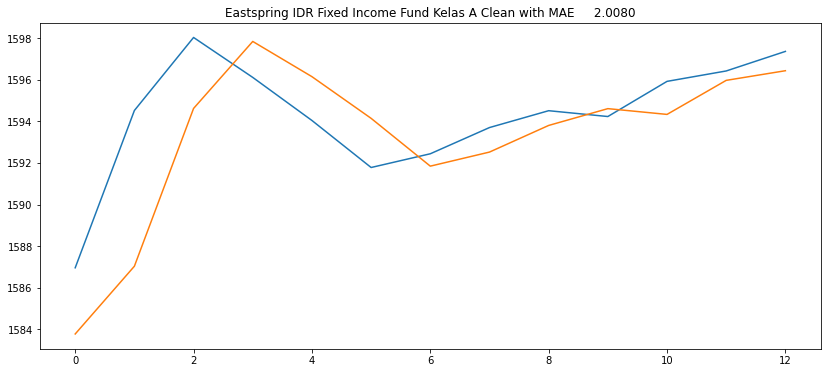

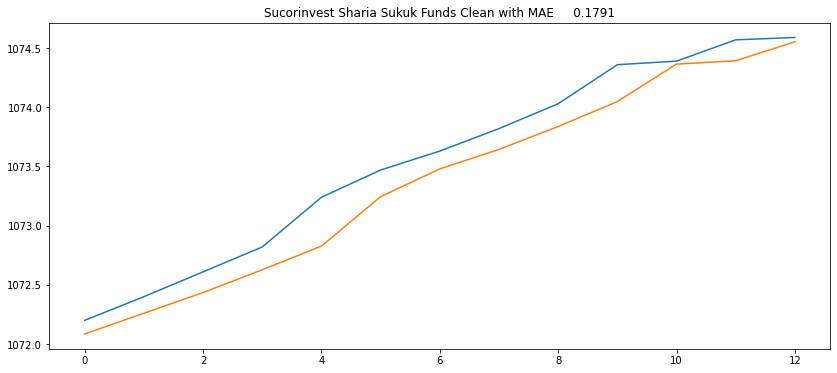

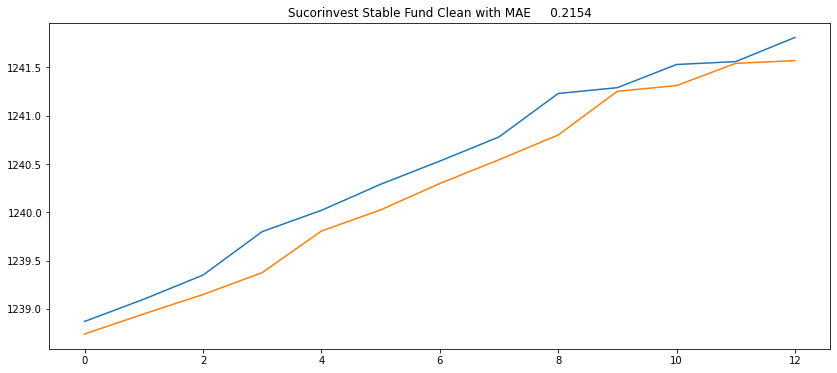

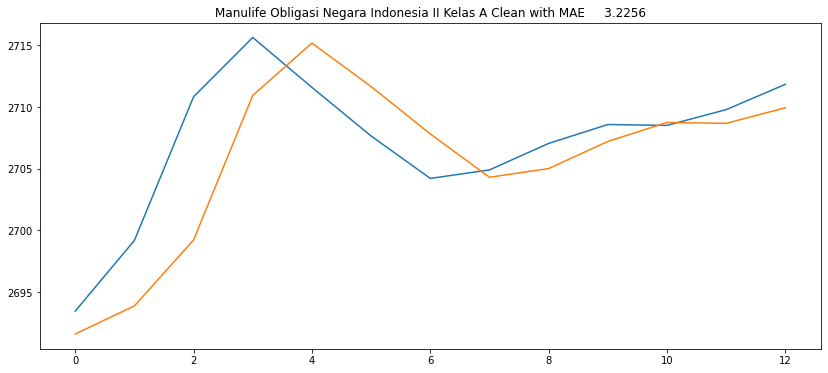

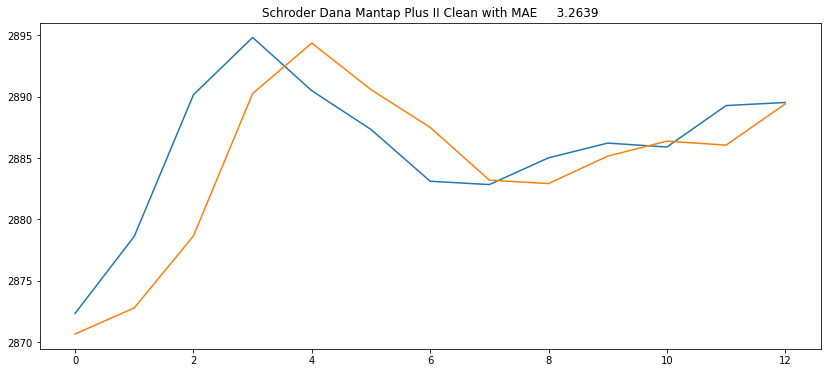

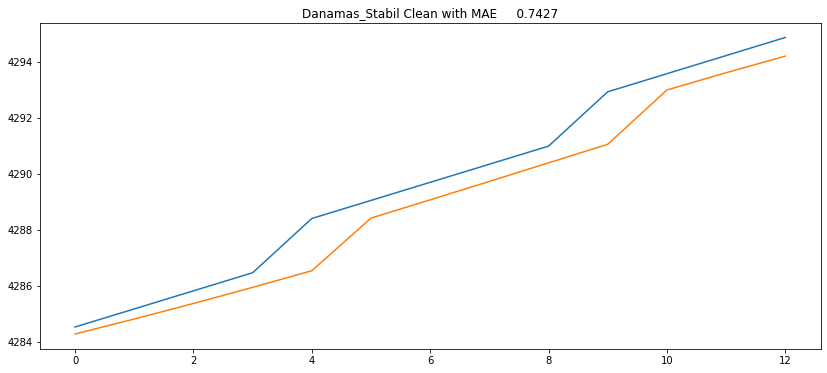

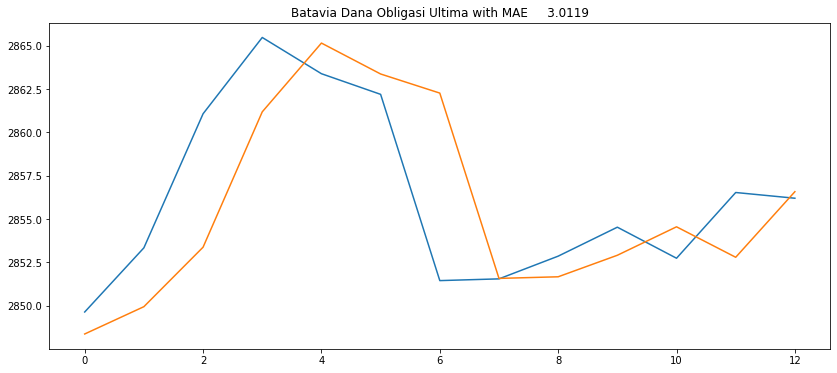

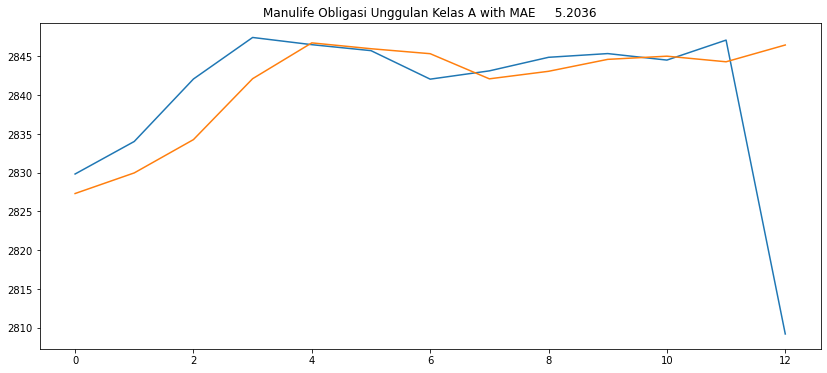

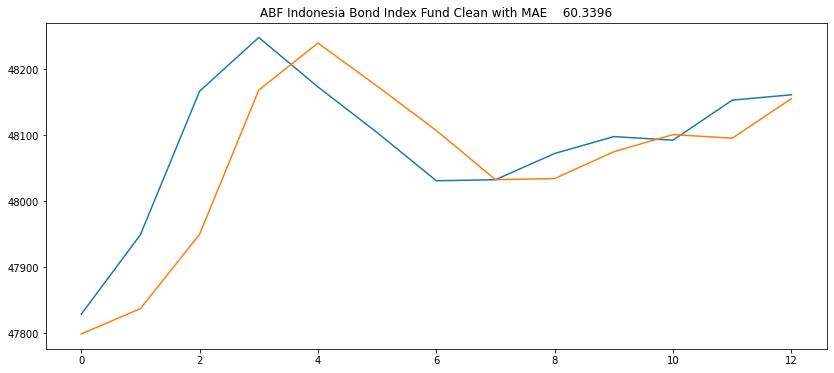

In [23]:
pred_result = {}
for i in dataset:
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(model.predict(testset[i]["X"]))
    MSE = mean_absolute_error(y_true, y_pred)
    pred_result[i] = {}
    pred_result[i]["True"] = y_true
    pred_result[i]["Pred"] = y_pred
    
    plt.figure(figsize=(14,6))
    plt.title("{} with MAE {:10.4f}".format(i,MSE))
    plt.plot(y_true)
    plt.plot(y_pred)